In [35]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


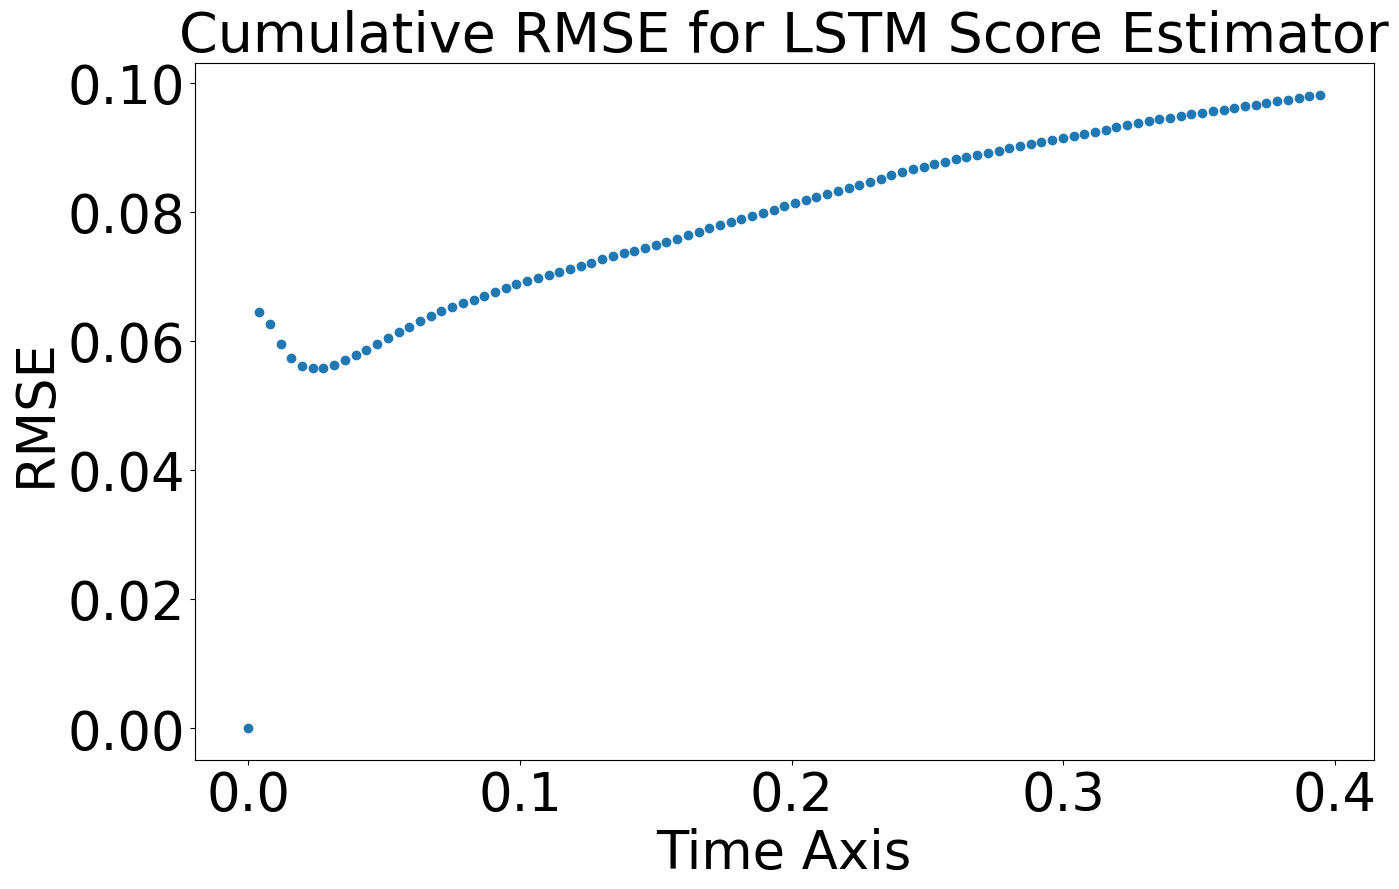

Final time cumulative RMSE local-time error 0.09814468077632622 at Nepoch 60 for 1.25FConst



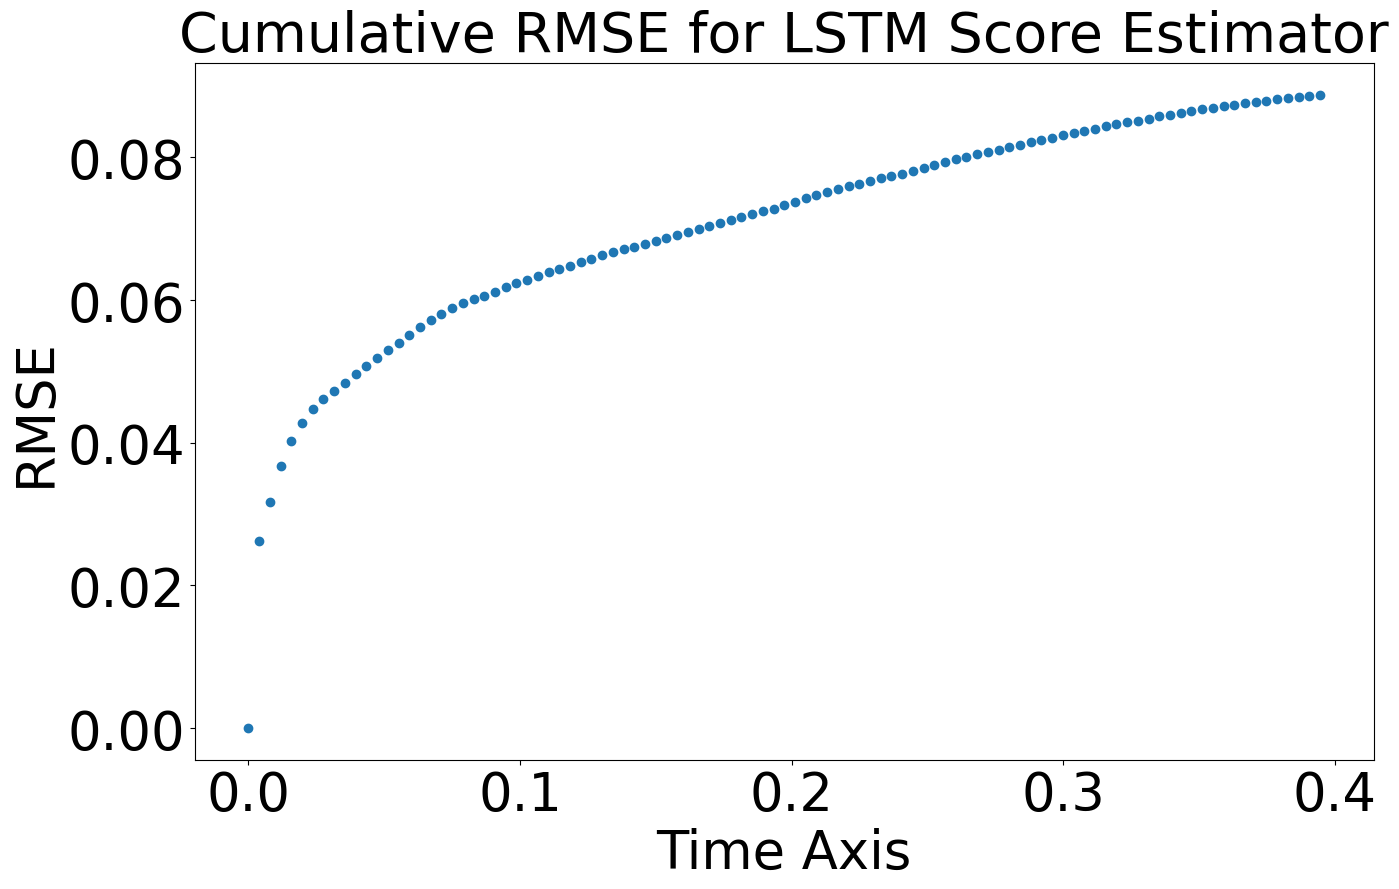

Final time cumulative RMSE local-time error 0.08879270885701282 at Nepoch 100 for 1.25FConst



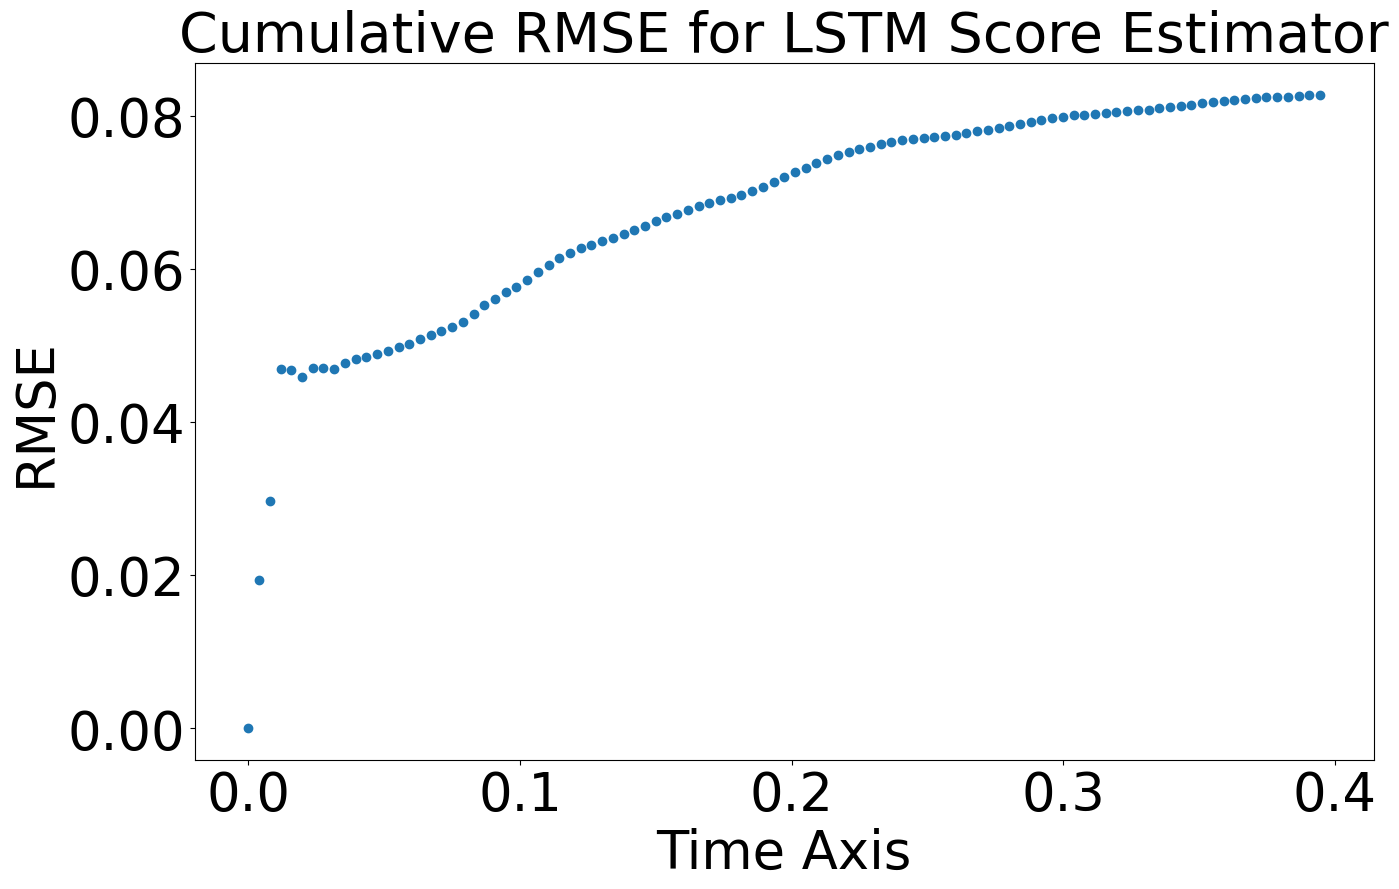

Final time cumulative RMSE local-time error 0.08273955063999278 at Nepoch 300 for 1.25FConst



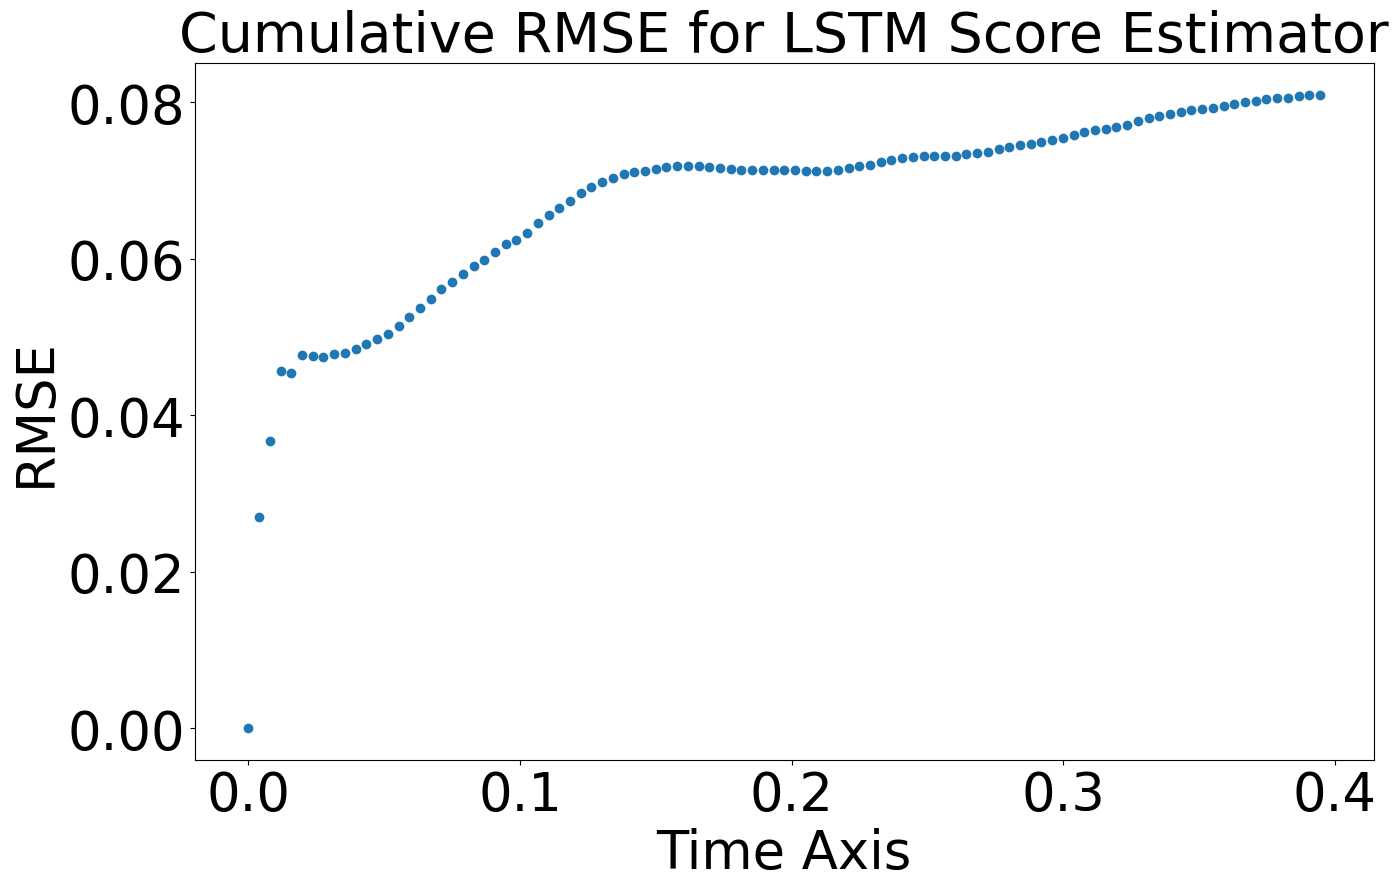

Final time cumulative RMSE local-time error 0.08096658442163804 at Nepoch 1440 for 1.25FConst



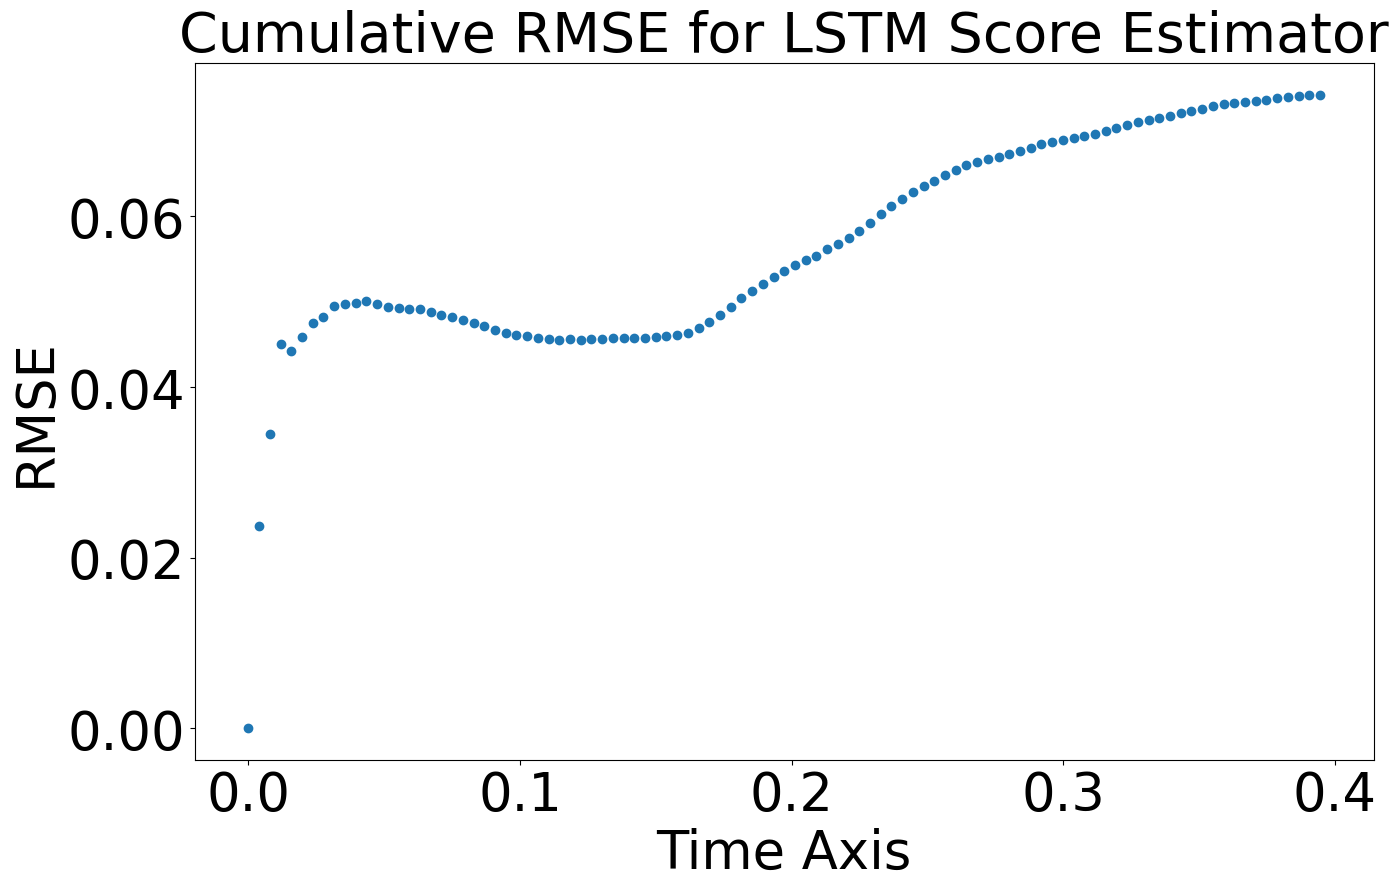

Final time cumulative RMSE local-time error 0.07428806052879657 at Nepoch 1920 for 1.25FConst



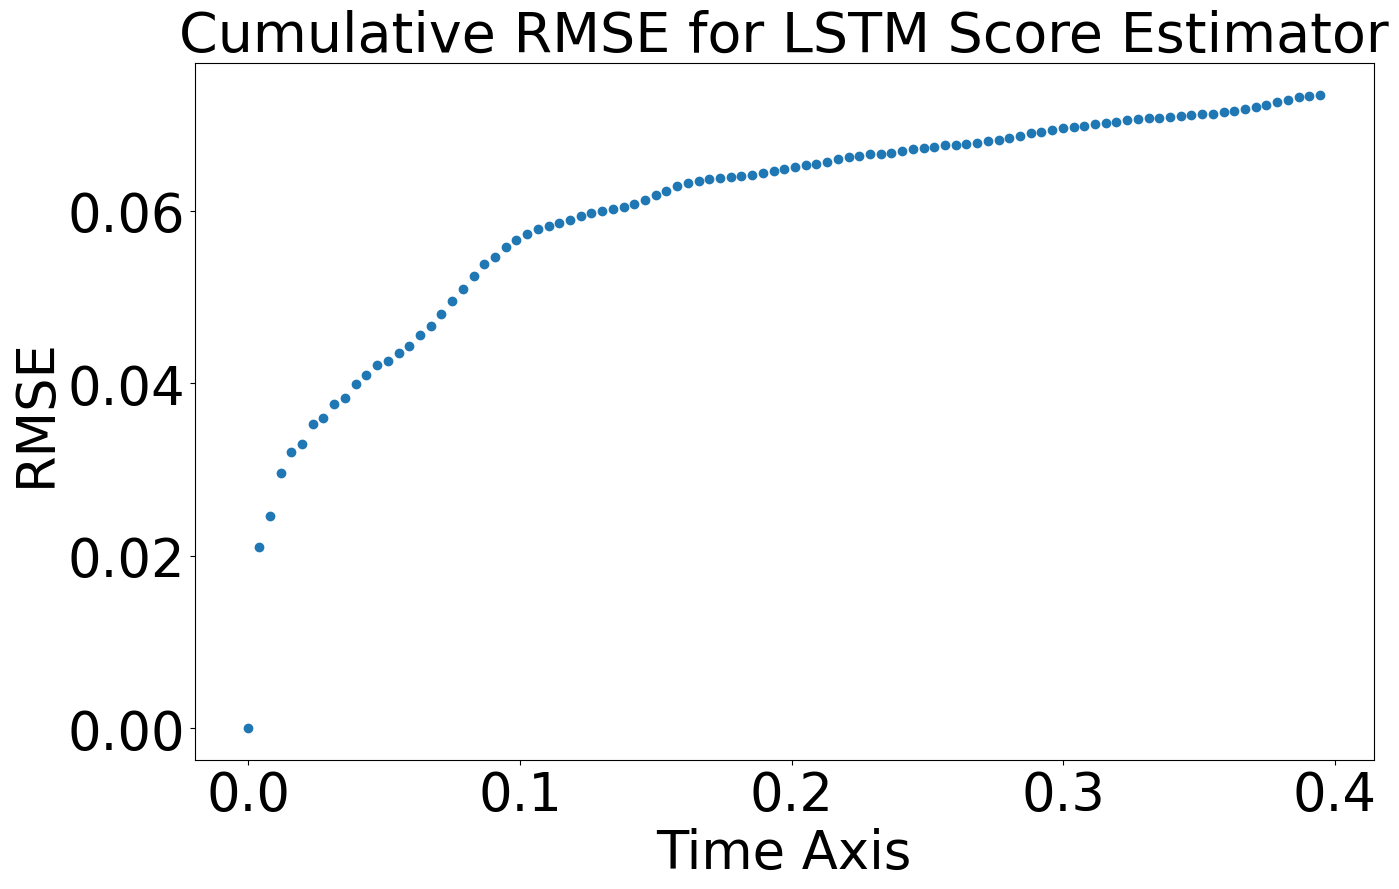

Final time cumulative RMSE local-time error 0.073469189806681 at Nepoch 8190 for 1.25FConst



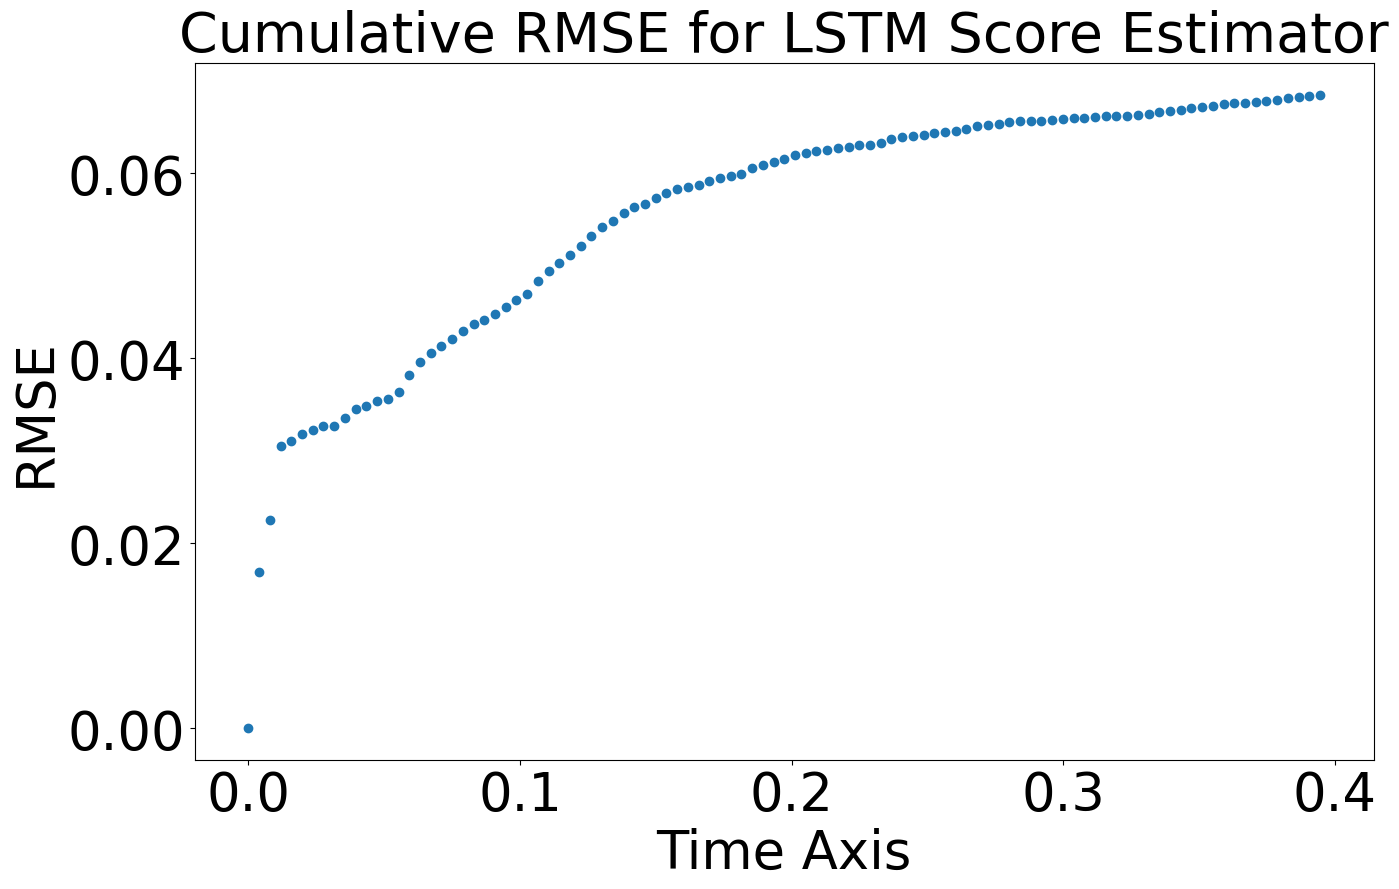

Final time cumulative RMSE local-time error 0.0684992777565769 at Nepoch 12920 for 1.25FConst



In [37]:
curr_rmse = np.inf
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
        true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
        total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue